In [169]:
import torch
import torch_geometric as pyg
import numpy as np
import torch.nn as nn
import pandas as pd
import networkx as nx
import pyvis
from pyvis.network import Network
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
from torch_geometric.nn import SAGEConv, GCNConv
from sklearn.metrics import roc_auc_score
import itertools
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import DataLoader, LinkNeighborLoader, NeighborLoader
import torch_geometric.utils as utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [55]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

In [4]:
# [0, 348, 414, 686, 698, 107, 3437, 1684, 1912, 3980]

In [170]:
USER = 0

file_edges = f'facebook/{USER}.edges'
file_feat = f'facebook/{USER}.feat'

edges = pd.read_csv(file_edges, sep=" ", header=None, names=["u", "v"])
feat = pd.read_csv(file_feat, sep=" ", header=None)

In [171]:
mapping = {x:i for i, x in enumerate(feat[0].unique())}

In [172]:
feat[0] = feat[0].map(mapping)
edges.u = edges.u.map(mapping)
edges.v = edges.v.map(mapping)

In [173]:
feat[0] = np.random.randint(0,2, 347)

In [174]:
edges = torch.tensor(edges.to_numpy().T, dtype=torch.int64)
feat = torch.tensor(feat.sort_values(by=0).to_numpy(), dtype=torch.float)

In [175]:
g = pyg.data.Data(x = feat[:, 1:], edge_index=edges)
g

Data(x=[347, 224], edge_index=[2, 5038])

In [176]:
n_g = pyg.utils.to_networkx(g)
# nx.draw(n_g)

In [179]:
pyvis_graph = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
pyvis_graph.from_nx(n_g)

In [180]:
pyvis_graph.show("graph.html")

In [213]:
transform = RandomLinkSplit(
    num_test=0.1, 
    num_val=0.1,
    is_undirected=True,
    split_labels=False, 
    add_negative_train_samples=False)
train, test, val = transform(g)

In [214]:
print(data)
print(train)
print(test)
print(val)

Data(x=[347, 224], edge_index=[2, 5038], y=[347], train_mask=[347], val_mask=[347], test_mask=[347])
Data(x=[347, 224], edge_index=[2, 4034], edge_label=[2017], edge_label_index=[2, 2017])
Data(x=[347, 224], edge_index=[2, 4034], edge_label=[502], edge_label_index=[2, 502])
Data(x=[347, 224], edge_index=[2, 4536], edge_label=[502], edge_label_index=[2, 502])


In [245]:
train_loader_ind = LinkNeighborLoader(train, num_neighbors=[25, 10], batch_size=128,
                                      neg_sampling_ratio=1.0, edge_label=train.edge_label,
                                      edge_label_index=train.edge_label_index,shuffle=True)
val_loader_ind = LinkNeighborLoader(val, num_neighbors=[25, 10], edge_label=val.edge_label,
                                    edge_label_index=val.edge_label_index, batch_size=128)
test_loader_ind = LinkNeighborLoader(test, num_neighbors=[25, 10], edge_label=test.edge_label,
                                     edge_label_index=test.edge_label_index, batch_size=128)

In [246]:
sample = next(iter(test_loader_ind))
print(sample)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


In [247]:
class EdgeClassificationSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Link predictor
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)
    
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
    def decode(self, z, edge_index):
        row, col = edge_index
        z_src = z[row]
        z_dst = z[col]
        z_cat = torch.cat([z_src, z_dst], dim=-1)
        
        z_cat = self.lin1(z_cat)
        z_cat = F.relu(z_cat)
        z_cat = F.dropout(z_cat, p=0.2, training=self.training)
        return self.lin2(z_cat).squeeze()
    
    def forward(self, x, edge_index, pred_edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, pred_edge_index)

In [263]:
def train_edge_classification(model, train_loader, val_loader, num_epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    best_val_auc = 0

    loss_track = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            out = model(batch.x, batch.edge_index, batch.edge_label_index)
            loss = F.binary_cross_entropy_with_logits(out, batch.edge_label)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        loss_track.append(total_loss/len(train_loader))
        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch.x, batch.edge_index, batch.edge_label_index)
                val_preds.append(out)
                val_labels.append(batch.edge_label)
        
        val_preds = torch.cat(val_preds, dim=0)
        val_labels = torch.cat(val_labels, dim=0)
        val_auc = roc_auc_score(val_labels.cpu(), val_preds.cpu())
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {total_loss/len(train_loader):.4f}, Val AUC: {val_auc:.4f}')

    return loss_track

In [264]:
model = EdgeClassificationSAGE(224, 128)

loss = train_edge_classification(model, train_loader_ind, val_loader_ind, 100)

Epoch 010, Loss: 0.2945, Val AUC: 0.9398
Epoch 020, Loss: 0.2508, Val AUC: 0.9324
Epoch 030, Loss: 0.2670, Val AUC: 0.9442
Epoch 040, Loss: 0.2339, Val AUC: 0.9554
Epoch 050, Loss: 0.2277, Val AUC: 0.9568
Epoch 060, Loss: 0.2071, Val AUC: 0.9583
Epoch 070, Loss: 0.2036, Val AUC: 0.9533
Epoch 080, Loss: 0.2158, Val AUC: 0.9528
Epoch 090, Loss: 0.1981, Val AUC: 0.9502
Epoch 100, Loss: 0.1850, Val AUC: 0.9571


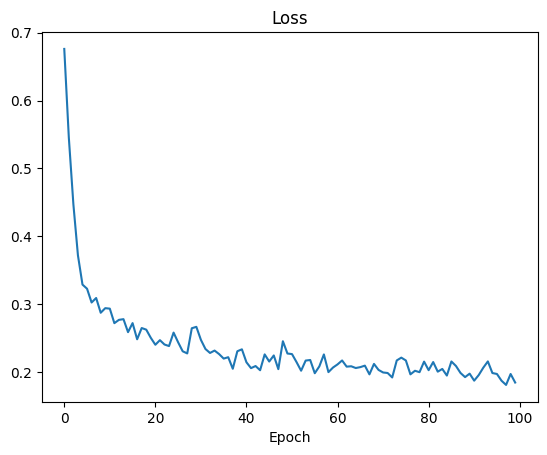

In [265]:
plt.title("Loss")
plt.xlabel("Epoch")
plt.plot(loss)

In [266]:
# --------- generate recommendation for user -------- #
def generate_rec(user_id=0, k=10):
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    
    for n1, n2 in train.edge_index.T:   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(train.x.shape[0]):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)
            
    model.eval()

    loader = NeighborLoader(
            g,
            num_neighbors=[25, 10],
            batch_size=len(user_neg_v+[user_id]),
            input_nodes=user_neg_v+[user_id],
            shuffle=False  # Keep order for mapping back to node IDs
        )

    
    for batch in loader:
        node_embed = model(batch.x, batch.edge_index, torch.stack([torch.tensor(user_neg_u), torch.tensor(user_neg_v)], dim=0))
    # calculate the score of each user
    scores = [(i, node_embed[i]) for i, v in enumerate(user_neg_v)]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of {k} suggested friends for user {user_id}:")
    for i in range(k):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')


In [267]:
generate_rec(user_id=0, k=20)

List of 20 suggested friends for user 0:
- User 305, score = 2.9730658531188965
- User 314, score = 2.812474250793457
- User 287, score = 2.7695672512054443
- User 299, score = 2.76239013671875
- User 199, score = 2.7022764682769775
- User 205, score = 2.6949048042297363
- User 130, score = 2.671621799468994
- User 239, score = 2.6646971702575684
- User 17, score = 2.619853973388672
- User 125, score = 2.6151843070983887
- User 122, score = 2.563253164291382
- User 102, score = 2.5454416275024414
- User 38, score = 2.543199062347412
- User 193, score = 2.4597291946411133
- User 143, score = 2.444223403930664
- User 41, score = 2.4212849140167236
- User 98, score = 2.414743423461914
- User 103, score = 2.402740478515625
- User 281, score = 2.3482251167297363
- User 25, score = 2.0139009952545166
